# MIDI music generation with GAN

Notebook presented for the A.A. 2023/2024 Deep Learning project.

Daniel Capannini - daniel.capannini@studio.unibo.it

In this notebook, GANs with different sized structures will be compared and the results obtained will be compared.

---

Below is the download of the dataset and installation of the libraries used.

In [1]:
!pip install miditok
!pip install pretty_midi
!pip install -q gdown
!pip install mido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=2b83834eb1070818a29dee56c7e0bdf7f0f28890b6f2c3beae8653cebea7da40
  Stored in directory: /root/.cache/pip/wheels/a4/f9/9e/08350c27e386558df0ae234e28a8facd145ba45506ddd1b989
Successfully built pretty_midi


In [2]:
import os
import shutil
from pathlib import Path
import numpy as np
from IPython.display import Audio, display
from miditok import REMI, TokenizerConfig
from pathlib import Path
from miditok.data_augmentation import augment_dataset
from miditok.utils import split_files_for_training
from random import shuffle
import json
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pretty_midi
import matplotlib.pyplot as plt
import glob
import mido
from collections import Counter
from scipy.special import rel_entr
import cupy as cp

np.random.seed(42)

## dataset

the dataset used is [MAESTRO dataset](https://magenta.withgoogle.com/datasets/maestro), which contains a collection of MIDIs from different piano performances.

New folder is created with all the MIDI files of the dataset.

In [3]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
!unzip 'maestro-v3.0.0-midi.zip'
!rm 'maestro-v3.0.0-midi.zip'
dataset_path = "maestro-v3.0.0"

--2025-09-23 06:10:43--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 173.194.217.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip’

maestro-v3.0.0-midi 100%[===================>]  55.71M   184MB/s    in 0.3s    

2025-09-23 06:10:43 (184 MB/s) - ‘maestro-v3.0.0-midi.zip’ saved [58416533/58416533]

Archive:  maestro-v3.0.0-midi.zip
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_01_Track01_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_T

In [4]:
destination_folder = "dataset_midi"
os.makedirs(destination_folder, exist_ok=True)

midi_paths = list(Path(dataset_path).resolve().glob("**/*.mid")) + \
             list(Path(dataset_path).resolve().glob("**/*.midi"))

print(f"Trovati {len(midi_paths)} file MIDI.")

for midi_path in midi_paths:
    filename = os.path.basename(midi_path)
    destination_path = os.path.join(destination_folder, filename)
    shutil.copy2(midi_path, destination_path)

print("Copia completata in 'dataset_midi'.")

midi_paths = [Path(os.path.join(destination_folder, os.path.basename(p))) for p in midi_paths]

Trovati 1276 file MIDI.
Copia completata in 'dataset_midi'.


## Data Analisis

A MIDI (Musical Instrument Digital Interface) file is a digital file format that stores instructions for playing music rather than the actual audio itself. Instead of containing recorded sound, a MIDI file includes data such as which notes are played, their duration, pitch, intensity, and the instruments to be used. This makes MIDI files very lightweight and versatile, as they can be played back on different devices and instruments, often sounding different depending on the sound library or synthesizer used.

Estimated time: 199.94214636968422


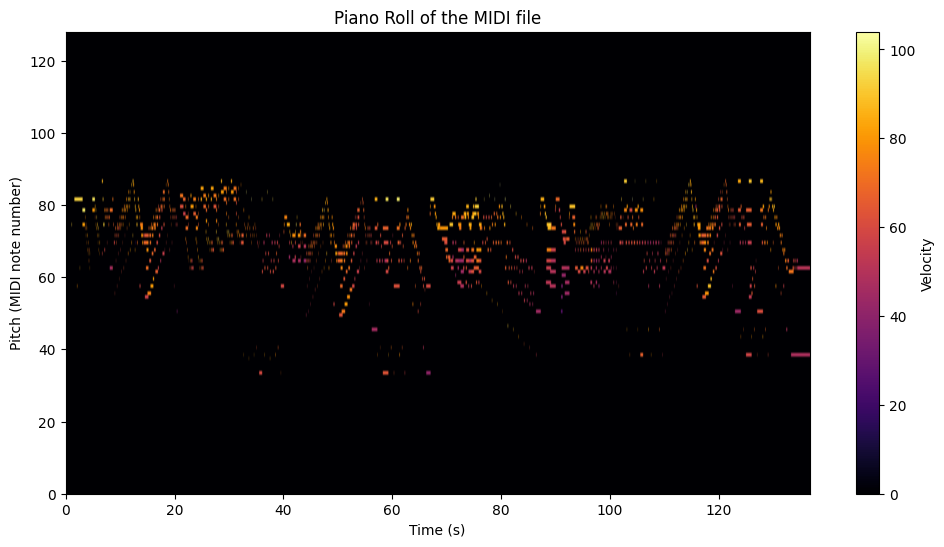

In [5]:
midi = pretty_midi.PrettyMIDI("/content/dataset_midi/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.midi")

print("Estimated time:", midi.estimate_tempo())

fs = 100
piano_roll = midi.get_piano_roll(fs=fs)

plt.figure(figsize=(12, 6))
plt.imshow(piano_roll[::-1], aspect='auto', cmap='inferno',
           extent=[0, piano_roll.shape[1]/fs, 0, 128])
plt.xlabel("Time (s)")
plt.ylabel("Pitch (MIDI note number)")
plt.title("Piano Roll of the MIDI file")
plt.colorbar(label="Velocity")
plt.show()


## Tokenizzazione

MIDI was not used directly for training, but was first tokenized using a tokenizer, which was trained below.

A tokenizer is a tool that converts raw MIDI data into a sequence of tokens that the AI ​​model can understand.

In the context of MIDI tokenization, each token represents a specific musical element or event, such as a note, velocity, or duration. These tokens serve as a "vocabulary" for the model, allowing it to learn and generate music.

In [ ]:
BEAT_RES = {(0, 1): 12, (1, 2): 4, (2, 4): 2, (4, 8): 1}
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": BEAT_RES,
    "num_velocities": 3,
    "special_tokens": ["BOS", "EOS"],
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "num_tempos": 8,
    "tempo_range": (50, 200),
}

The chosen tokenizer parameters aim to balance musical expressiveness with computational efficiency. The pitch_range limits tokens to the realistic span of a piano, avoiding unnecessary notes. The beat_res dictionary defines different time resolutions across measures, ensuring fine rhythmic detail where it matters and coarser granularity elsewhere, which keeps the sequence length manageable. Velocity values are reduced to just three discrete levels, simplifying dynamics while preserving expressive contrast. Special tokens like BOS and EOS mark the start and end of sequences, a common practice in sequence modeling. Enabling chords, rests, and tempos provides richer musical structure, while the tempo values are quantized into eight categories within a practical BPM range. Altogether, these parameters create a compact yet musically meaningful vocabulary, making it easier for a model to learn and generate coherent music.

In [ ]:
midi_dir = Path(destination_folder)
midis = list(midi_dir.glob("**/*.mid")) + list(midi_dir.glob("**/*.midi"))

if not midis:
    raise FileNotFoundError("Nessun file MIDI trovato in 'dataset_midi'.")

##Train tokenizer

In [ ]:
config = TokenizerConfig(**TOKENIZER_PARAMS)

tokenizer = REMI(config)

vocab_size = 5000
tokenizer.train(vocab_size=vocab_size, files_paths=midis)
processed = [Path(f"{s}") for s in midis]
print(len(processed))

In [ ]:
tokenizer.save("tokenizerMIDI")

## download tokenizer

execute the next 2 cells to skip tokenizer training

In [7]:
!gdown --id 12der1lMHfMyMbGWImONehL_43AoECyzB

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12der1lMHfMyMbGWImONehL_43AoECyzB
To: /content/tokenizer (2).json
100% 271k/271k [00:00<00:00, 145MB/s]


In [8]:
tokenizer = REMI(params="tokenizer (2).json")

## Dataset preparation

organizes a MIDI dataset by collecting all MIDI files, splitting them into train/validation subsets, and then applying preprocessing steps. Specifically, it chunks the training and validation files into sequences suitable for modeling, applies data augmentation (pitch, velocity, duration variations), and finally reloads the processed files for each subset.

In [9]:

base_dir = Path("/content/dataset_midi").resolve()

midis = list(base_dir.glob("**/*.mid")) + list(base_dir.glob("**/*.midi"))
midis = [midi.resolve() for midi in midis]

total_num_files = len(midis)
num_files_test = round(total_num_files * 0.20)

np.random.shuffle(midis)

midi_paths_test = midis[:num_files_test]
midi_paths_train = midis[num_files_test:]

train_dir = Path("dataset_train")
test_dir = Path("dataset_test")
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

for src_path in midi_paths_train:
    shutil.copy(src_path, train_dir / src_path.name)

for src_path in midi_paths_test:
    shutil.copy(src_path, test_dir / src_path.name)

# Chunk e augment
for files_paths, subset_name in (
    (midi_paths_train, "train"),
    (midi_paths_test, "test")
):
    subset_chunks_dir = Path(f"Maestro_{subset_name}")

    split_files_for_training(
        files_paths=files_paths,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

    augment_dataset(
        subset_chunks_dir,
        pitch_offsets=[-12, 12],
        velocity_offsets=[-3, 3],
        duration_offsets=[-0.5, 0.5],
    )

midi_paths_train = list(Path("Maestro_train").glob("**/*.mid")) + list(Path("Maestro_train").glob("**/*.midi"))
midi_paths_test = list(Path("Maestro_test").glob("**/*.mid")) + list(Path("Maestro_test").glob("**/*.midi"))


Performing data augmentation: 100%|██████████| 2532/2532 [00:04<00:00, 558.05it/s]


In [10]:
!zip -r dataset_train.zip dataset_train
!zip -r dataset_test.zip dataset_test

  adding: dataset_train/ (stored 0%)
  adding: dataset_train/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--1.midi (deflated 37%)
  adding: dataset_train/MIDI-Unprocessed_03_R1_2006_01-05_ORIG_MID--AUDIO_03_R1_2006_04_Track04_wav.midi (deflated 34%)
  adding: dataset_train/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--3.midi (deflated 26%)
  adding: dataset_train/MIDI-Unprocessed_073_PIANO073_MID--AUDIO-split_07-08-17_Piano-e_2-02_wav--1.midi (deflated 27%)
  adding: dataset_train/MIDI-Unprocessed_14_R1_2006_01-05_ORIG_MID--AUDIO_14_R1_2006_03_Track03_wav.midi (deflated 33%)
  adding: dataset_train/MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--2.midi (deflated 27%)
  adding: dataset_train/MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_02_Track02_wav.midi (deflated 32%)
  adding: dataset_train/MIDI-Unprocessed_02_R1_2006_01-04_ORIG_MID--AUDIO_02_R1_2006_03_Track03_wav.midi (deflated 28%)
  adding: dataset_train/MIDI-Unprocessed_R1

All MIDI files from the training and testing set are tokenized so they can be used to train the GAN.

In [11]:
def midi_valid(midi) -> bool:
    if any(ts.numerator != 4 for ts in midi.time_signature_changes):
        return False  # time signature different from 4/*, 4 beats per bar
    return True

if os.path.exists("tokenized"):
  shutil.rmtree("tokenized")

for dir in ("train", "test"):
    tokenizer.tokenize_dataset(
        Path(f"Maestro_{dir}").resolve(),
        Path(f"tokenized_{dir}").resolve(),
        midi_valid,
    )

Tokenizing music files (content/tokenized_test): 100%|██████████| 15217/15217 [04:45<00:00, 53.36it/s]


In [12]:
!zip -r tokenized_train.zip tokenized_train
!zip -r tokenized_test.zip tokenized_test

Output streaming troncato alle ultime 5000 righe.
  adding: tokenized_test/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_21_R2_2015_wav--1_4.json (deflated 63%)
  adding: tokenized_test/MIDI-Unprocessed_XP_19_R1_2004_01-02_ORIG_MID--AUDIO_19_R1_2004_03_Track03_wav_7.json (deflated 63%)
  adding: tokenized_test/MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--5_0#d240.json (deflated 71%)
  adding: tokenized_test/MIDI-Unprocessed_048_PIANO048_MID--AUDIO-split_07-06-17_Piano-e_2-05_wav--2_2#p12.json (deflated 66%)
  adding: tokenized_test/MIDI-Unprocessed_23_R1_2011_MID--AUDIO_R1-D9_05_Track05_wav_0#d-192.json (deflated 65%)
  adding: tokenized_test/MIDI-Unprocessed_Schubert10-12_MID--AUDIO_17_R2_2018_wav_18.json (deflated 62%)
  adding: tokenized_test/MIDI-Unprocessed_XP_21_R1_2004_03_ORIG_MID--AUDIO_21_R1_2004_04_Track04_wav_8#d-240.json (deflated 65%)
  adding: tokenized_test/MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--4_0#v3.json (def

## download the tokenized dataset

In [ ]:
!gdown --id 1sYpjsu1Oheij9w4C0ssWgYNNebeLv-Zd
!gdown --id 1yENUMEQ-IIgBL1Kp-lhfTiab8A0XOjS8

!unzip tokenized_test.zip
!unzip tokenized_train.zip

## Read JSON

Here we read the produced JSON files containing the tokenization's output.

In [ ]:
def load_json(filepath: str) -> dict:
    """Load a JSON file and return its contents."""
    try:
        with open(filepath, "r") as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Skipping {filepath}: {e}")
        return None


def load_multiple_jsons(file_paths):
    """Load multiple JSON files into a list of objects."""
    results = []
    for fp in tqdm(file_paths, desc="Reading JSON files"):
        obj = load_json(fp)
        if obj is not None:
            results.append(obj)
    return results

train_jsons = Path("tokenized_train").resolve().rglob("*.json")
test_jsons = Path("tokenized_test").resolve().rglob("*.json")

train_data = load_multiple_jsons(train_jsons)
test_data = load_multiple_jsons(test_jsons)

if train_data and test_data:
    print(f"\nLoaded {len(train_data)} JSON files for training.")
else:
    print("Some JSON files could not be read.")


Reading JSON files: 58142it [00:10, 5407.55it/s]
Reading JSON files: 0it [00:00, ?it/s]

Some JSON files could not be read.


Rather than padding each MIDI file (converted into tokens) to a fixed length with special padding tokens, we instead concatenate the token IDs of all piano pieces into a single large Numpy array. This approach comes with trade-offs—most notably a loss of musical coherence when sequences are passed to the model and a weaker sense of each song as a complete unit—but it provides much greater flexibility in handling and processing the dat

In [ ]:
def extract_ids(data_objects):
    """Extract and convert token IDs from JSON objects."""
    arrays = []
    for obj in data_objects:
        if "ids" in obj and isinstance(obj["ids"], list) and len(obj["ids"]) > 0:
            arrays.append(np.asarray(obj["ids"][0], dtype=np.int32))
    return np.concatenate(arrays, axis=0)

all_ids_train = extract_ids(train_data)
all_ids_test = extract_ids(test_data)

## GAN model

The system is based on the structure of a Generative Adversarial Network (GAN) and consists of two main components:

Generator Network: a fully connected neural network that takes a random noise vector as input and produces a MIDI file as output (Generated MIDI). The generator's objective is to create data that closely mimics authentic data. This component embodies the creative aspect of the GAN architecture.

Discriminator Network: another fully connected neural network that receives as input both authentic MIDI files (from the Maestro Dataset) and MIDI files produced by the generator. The discriminator's function is to classify these inputs as either authentic (True) or synthetic (False). This component embodies the evaluative aspect of the GAN architecture.

Training process: The generator enhances its performance by attempting to fool the discriminator, creating data that the discriminator finds progressively more challenging to distinguish from authentic data. Simultaneously, the discriminator is optimized to become more precise at identifying the distinction between authentic and generated data. This adversarial process relies on a loss function calculated for both networks, with weight updates executed using the ADAM optimizer.

To evaluate performance variation in relation to model complexity, three generators and three discriminators were trained with the same overall architecture but varying sizes:

- Mini,
- Medium,
- Large.

These models share the same fundamental architecture but differ in the number of neurons and layers, enabling a comparative analysis of their performance in relation to representational capacity.

In [ ]:
class GeneratorMini(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, output_length),
            nn.Tanh()
        )

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        return self.model(noise_vector)


class DiscriminatorMini(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_length, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, 1)
        )

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        return self.model(sequence)


In [ ]:
class GeneratorMedium(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim * 8),
            nn.ReLU(),
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, output_length),
            nn.Tanh()
        )

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        return self.model(noise_vector)


class DiscriminatorMedium(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_length, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 8, 1)
        )

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        return self.model(sequence)


In [ ]:
class GeneratorLarge(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim * 16),
            nn.ReLU(),
            nn.Linear(hidden_dim * 16, hidden_dim * 8),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, output_length),
            nn.Tanh()
        )

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        return self.model(noise_vector)


class DiscriminatorLarge(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_length, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 8, hidden_dim * 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 16, 1)
        )

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        return self.model(sequence)


## GAN class

This GAN class implements the logic required to train a Generative Adversarial Network (GAN) composed of a generator and a discriminator. Both models are passed as arguments to the constructor, along with the input noise size, the length of the musical sequence, and the tokenizer used to manage the MIDI data. The class independently manages the optimizers, weight initialization, and loss function calculation, allowing the two models to be trained in a coordinated manner.

During training, the discriminator learns to distinguish between real MIDI files (from the dataset) and those generated by the generator, while the generator attempts to produce increasingly convincing sequences capable of fooling the discriminator. The class also manages alternating training strategies to balance the update steps of the two models and includes checks to avoid numerical instabilities such as NaN or Inf values. It also provides methods to save the weights of the trained models, generate new sequences as numeric arrays, and convert them into real MIDI files, ready to be listened to and analyzed.

In [ ]:

class MidiGAN:
    def __init__(
        self,
        generator: nn.Module,
        discriminator: nn.Module,
        noise_dim: int,
        sequence_length: int,
        tokenizer,
        loss_fn: nn.Module = nn.BCEWithLogitsLoss(),
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.noise_dim = noise_dim
        self.sequence_length = sequence_length
        self.loss_fn = loss_fn
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer)

        self.generator_optimizer = torch.optim.Adam(
            self.generator.parameters(), lr=0.00005, betas=(0.5, 0.999)
        )
        self.discriminator_optimizer = torch.optim.Adam(
            self.discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999)
        )

        self.generator.apply(self._init_weights)
        self.discriminator.apply(self._init_weights)

    def save(self, filepath: str):
        torch.save(
            {
                "generator": self.generator.state_dict(),
                "discriminator": self.discriminator.state_dict(),
            },
            filepath,
        )
        print(f"Generator + Discriminator weights saved to {filepath}")

    @staticmethod
    def load(
        generator_class,
        discriminator_class,
        filepath: str,
        noise_dim: int,
        sequence_length: int,
        tokenizer,
        map_location: str = "cpu",
        gen_kwargs={},
        disc_kwargs={},
    ):
        checkpoint = torch.load(filepath, map_location=map_location)
        generator = generator_class(**gen_kwargs)
        discriminator = discriminator_class(**disc_kwargs)
        generator.load_state_dict(checkpoint["generator"])
        discriminator.load_state_dict(checkpoint["discriminator"])
        print(f"Generator + Discriminator weights loaded from {filepath}")

        return MidiGAN(
            generator=generator,
            discriminator=discriminator,
            noise_dim=noise_dim,
            sequence_length=sequence_length,
            tokenizer=tokenizer,
        )

    def train(
        self,
        dataloader,
        epochs: int,
        device: torch.device,
        loss_delta: float = 0.7,
        steps_each_print: int = 5,
        advantage_steps: int = 2,
        alternate_training: bool = False,
        generator_steps: int = 1,
        discriminator_steps: int = 1,
    ):
        print(f"Starting training for {epochs} epochs")
        self.generator.to(device).train()
        self.discriminator.to(device).train()

        all_d_losses, all_g_losses = [], []

        for epoch in range(epochs):
            epoch_d_losses, epoch_g_losses = [], []
            pbar = tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}")
            for step, real_batch in enumerate(dataloader):
                batch_size = real_batch.size(0)
                real_batch = real_batch.to(device)

                d_loss, g_loss = self._train_batch(
                    batch_size, real_batch, device, generator_steps, discriminator_steps
                )
                all_d_losses.append(d_loss)
                all_g_losses.append(g_loss)
                epoch_d_losses.append(d_loss)
                epoch_g_losses.append(g_loss)

                if alternate_training:
                    if g_loss - d_loss > loss_delta:
                        generator_steps, discriminator_steps = advantage_steps, 1
                    elif d_loss - g_loss > loss_delta:
                        discriminator_steps, generator_steps = advantage_steps, 1
                    else:
                        generator_steps, discriminator_steps = 1, 1

                if (step + 1) % steps_each_print == 0:
                    desc = f"D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}"
                    if generator_steps != 1 or discriminator_steps != 1:
                        desc += f" | D Steps: {discriminator_steps}, G Steps: {generator_steps}"
                    pbar.set_description(desc)
                pbar.update(1)

            pbar.close()
            mean_d_loss = np.mean(epoch_d_losses)
            mean_g_loss = np.mean(epoch_g_losses)
            print(f"Epoch {epoch+1}/{epochs} | Mean D Loss: {mean_d_loss:.4f} | Mean G Loss: {mean_g_loss:.4f}")

        return all_d_losses, all_g_losses

    def _generator_train_step(self, batch_size: int, device: torch.device) -> float:
        self.generator.zero_grad()
        noise = self._sample_noise(batch_size, device)
        fake_data = self.generator(noise)
        fake_predictions = self.discriminator(fake_data)

        loss_g = -torch.mean(fake_predictions)
        if not (torch.isnan(loss_g) or torch.isinf(loss_g)):
            loss_g.backward()
            torch.nn.utils.clip_grad_norm_(self.generator.parameters(), max_norm=1.0)
            self.generator_optimizer.step()
        else:
            print("NaN or Inf detected in generator loss.")
        return loss_g.item()

    def _discriminator_train_step(
        self, batch_size: int, real_data: torch.Tensor, device: torch.device
    ) -> float:
        self.discriminator.zero_grad()
        noise = self._sample_noise(batch_size, device)
        fake_data = self.generator(noise)

        real_predictions = self.discriminator(real_data)
        fake_predictions = self.discriminator(fake_data)

        real_labels = torch.ones_like(real_predictions)
        fake_labels = torch.zeros_like(fake_predictions)

        loss_real = self.loss_fn(real_predictions, real_labels)
        loss_fake = self.loss_fn(fake_predictions, fake_labels)

        loss_d = loss_real + loss_fake
        if not (torch.isnan(loss_d) or torch.isinf(loss_d)):
            loss_d.backward()
            self.discriminator_optimizer.step()
        else:
            print("NaN or Inf detected in discriminator loss.")
        return loss_d.item()

    def _train_batch(
        self, batch_size: int, real_data: torch.Tensor, device: torch.device,
        generator_steps: int, discriminator_steps: int
    ):
        d_losses = [
            self._discriminator_train_step(batch_size, real_data, device)
            for _ in range(discriminator_steps)
        ]
        g_losses = [
            self._generator_train_step(batch_size, device)
            for _ in range(generator_steps)
        ]
        return np.mean(d_losses), np.mean(g_losses)

    def _init_weights(self, layer):
        if isinstance(layer, (nn.Linear, nn.Conv1d)):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def _sample_noise(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.randn(batch_size, self.noise_dim, device=device)

    def predict(self, n_samples: int, device: torch.device):
        noise = self._sample_noise(n_samples, device)
        return self.generator(noise).cpu().detach().numpy()

    def generate_midi(self, n_samples: int, output_prefix: str, device: torch.device):
        predictions = self.predict(n_samples, device)
        midpoint = self.vocab_size // 2
        predictions = [x * midpoint + midpoint for x in predictions]

        for i, pred in enumerate(predictions):
            tokens = pred.astype(np.int32)
            tokens[tokens == self.vocab_size] = 0
            try:
                midi_obj = self.tokenizer.decode([tokens])
                midi_obj.dump_midi(f"{output_prefix}_{i}.mid")
                print(f"MIDI generated: {output_prefix}_{i}.mid")
            except Exception as e:
                print(f"Error generating MIDI for sample {i}: {e}")


The TokenDataset class and the normalize_data function prepare the input data for GAN training. Specifically, TokenDataset defines a custom dataset containing token sequences (derived from the MIDI file) and makes them compatible with PyTorch, returning 32-bit floating-point numeric tensors, ready for use in data loaders. The normalize_data function, on the other hand, normalizes the token values ​​to a range between -1 and 1, so they better fit the generator's widely used activation function. This normalization step is crucial because it ensures numerical stability and speeds up convergence during training, reducing the risk of gradients that are too large or too small.

In [ ]:
class TokenDataset(Dataset):
    """Dataset of normalized token sequences for GAN training."""
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32)


def normalize_data(token_array, vocab_size: int):
    """
    Normalize input data to a interval = (-1, 1).
    """
    min_val, max_val = (-1, 1)
    normalized = (token_array - vocab_size / 2) / (vocab_size / 2)
    scaled = normalized * (max_val - min_val) / 2 + (max_val + min_val) / 2
    return scaled


Hyper-parameters kept unchanged for training each model

In [ ]:
vocab_size = len(tokenizer)
seq_length = 512
noise_dim = 512
hidden_dim = 1536
batch_size = 128

generator_config = {
    "noise_dim"  : noise_dim,
    "hidden_dim" : hidden_dim,
    "output_length" : seq_length
}


discriminator_config = {
    "input_length" : seq_length,
    "hidden_dim" : hidden_dim
}

## Trainig GAN Mini

## Setup for training

It then initializes the GAN generator and discriminator, configures the computing device (CPU or GPU), and prepares the data for training. Specifically, the MIDI tokens are normalized to the range
−1, 1, split into sequences of the desired length, and organized into a PyTorch dataset managed by DataLoader, which handles batching and shuffling. Finally, a quick test is performed on the GPU and the dataset information is printed to confirm that the system is ready for training.

This operation is also performed for training the other models.

In [ ]:

generator = GeneratorMini(**generator_config)
discriminator = DiscriminatorMini(**discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "sequence_length"          : seq_length,
    "tokenizer"                : tokenizer,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0) if torch.cuda.is_available() else None

sequence_length = seq_length
batch_size = batch_size

vocab_size = len(tokenizer)
normalized_tokens = normalize_data(all_ids_train, vocab_size)

print(f"Normalization completed | Max: {normalized_tokens.max():.4f}, Min: {normalized_tokens.min():.4f}")

sequences = [
    normalized_tokens[i : i + sequence_length]
    for i in range(0, len(normalized_tokens) - sequence_length, sequence_length)
]

dataset = TokenDataset(sequences)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4
)

_ = torch.ones(1, device=device)
print(f"Dataset ready. Batch size: {batch_size}, Number of batches: {len(dataloader)}")


Normalization completed | Max: 0.9996, Min: -0.9988
Dataset ready. Batch size: 128, Number of batches: 899


In [ ]:
gan_mini = MidiGAN(**gan_params)

training_arguments = {
    "dataloader"            : dataloader,
    "epochs"                : 45,
    "device"                : device,
    "steps_each_print"      : 10,
    "generator_steps"       : 1,
    "discriminator_steps"   : 1,
}

losses_discriminator, losses_generator = gan_mini.train(**training_arguments)

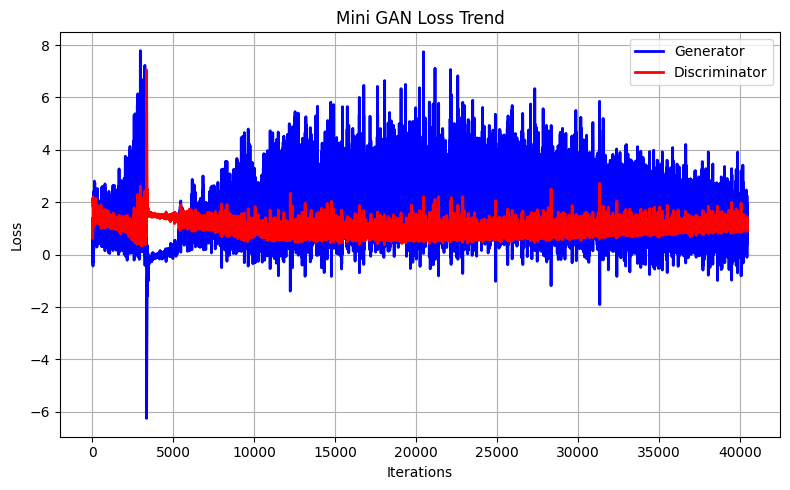

In [ ]:

iterations = list(range(1, len(losses_discriminator) + 1))

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generator", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminator", color="red", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Mini GAN Loss Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gan_mini.save("mini_gan.pth")

load GAN mini

In [ ]:
!gdown --id 1mxtxUgz3OkZmXMUU6RArrZgLUY14ntLN

gan_mini = MidiGAN.load(
    generator_class=GeneratorMini,
    discriminator_class=DiscriminatorMini,
    filepath="mini_gan.pth",
    noise_dim=512,
    sequence_length=512,
    tokenizer=tokenizer,
    gen_kwargs=generator_config,
    disc_kwargs=discriminator_config,
)


## Trainig GAN Medium

In [ ]:

generator = GeneratorMedium(**generator_config)
discriminator = DiscriminatorMedium(**discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "sequence_length"          : seq_length,
    "tokenizer"                : tokenizer,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0) if torch.cuda.is_available() else None

sequence_length = seq_length
batch_size = batch_size
vocab_size = len(tokenizer)
normalized_tokens = normalize_data(all_ids_train, vocab_size)

print(f"Normalizzazione completata | Max: {normalized_tokens.max():.4f}, Min: {normalized_tokens.min():.4f}")

sequences = [
    normalized_tokens[i : i + sequence_length]
    for i in range(0, len(normalized_tokens) - sequence_length, sequence_length)
]

dataset = TokenDataset(sequences)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4
)

_ = torch.ones(1, device=device)
print(f"Dataset pronto. Batch size: {batch_size}, Numero batch: {len(dataloader)}")

Normalizzazione completata | Max: 0.9996, Min: -0.9988
Dataset pronto. Batch size: 128, Numero batch: 899


In [ ]:
gan_medium = MidiGAN(**gan_params)

training_arguments = {
    "dataloader"            : dataloader,
    "epochs"                : 45,
    "device"                : device,
    "steps_each_print"      : 10,
    "generator_steps"       : 1,
    "discriminator_steps"   : 1,
}

losses_discriminator, losses_generator = gan_medium.train(**training_arguments)

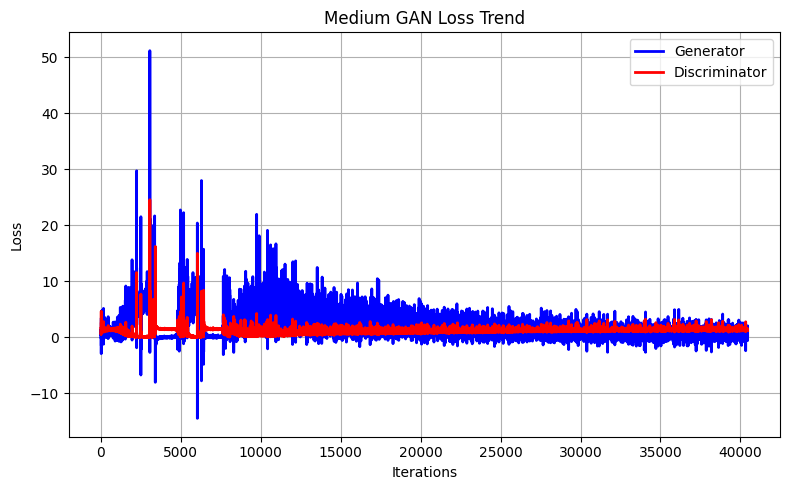

In [ ]:

iterations = list(range(1, len(losses_discriminator) + 1))

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generator", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminator", color="red", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Medium GAN Loss Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gan_medium.save("gan_medium.pth")

Generator + Discriminator weights saved to gan_medium.pth


load GAN medium

In [ ]:
!gdown --id 1qzggLn-atZUmXvMliblsCBV5vxKtq6A6

gan_medium = MidiGAN.load(
    generator_class=GeneratorMedium,
    discriminator_class=DiscriminatorMedium,
    filepath="gan_medium.pth",
    noise_dim=512,
    sequence_length=512,
    tokenizer=tokenizer,
    gen_kwargs=generator_config,
    disc_kwargs=discriminator_config,
)

## Trainig GAN Large

In [ ]:

generator = GeneratorLarge(**generator_config)
discriminator = DiscriminatorLarge(**discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "sequence_length"          : seq_length,
    "tokenizer"                : tokenizer,
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0) if torch.cuda.is_available() else None

sequence_length = seq_length
batch_size = batch_size
vocab_size = len(tokenizer)
normalized_tokens = normalize_data(all_ids_train, vocab_size)

print(f"Normalizzazione completata | Max: {normalized_tokens.max():.4f}, Min: {normalized_tokens.min():.4f}")

sequences = [
    normalized_tokens[i : i + sequence_length]
    for i in range(0, len(normalized_tokens) - sequence_length, sequence_length)
]

dataset = TokenDataset(sequences)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4
)

_ = torch.ones(1, device=device)
print(f"Dataset pronto. Batch size: {batch_size}, Numero batch: {len(dataloader)}")

Normalizzazione completata | Max: 0.9996, Min: -0.9988
Dataset pronto. Batch size: 128, Numero batch: 899


In [ ]:
gan_large = MidiGAN(**gan_params)

training_arguments = {
    "dataloader"            : dataloader,
    "epochs"                : 45,
    "device"                : device,
    "steps_each_print"      : 10,
    "generator_steps"       : 1,
    "discriminator_steps"   : 1,
}

losses_discriminator, losses_generator = gan_large.train(**training_arguments)

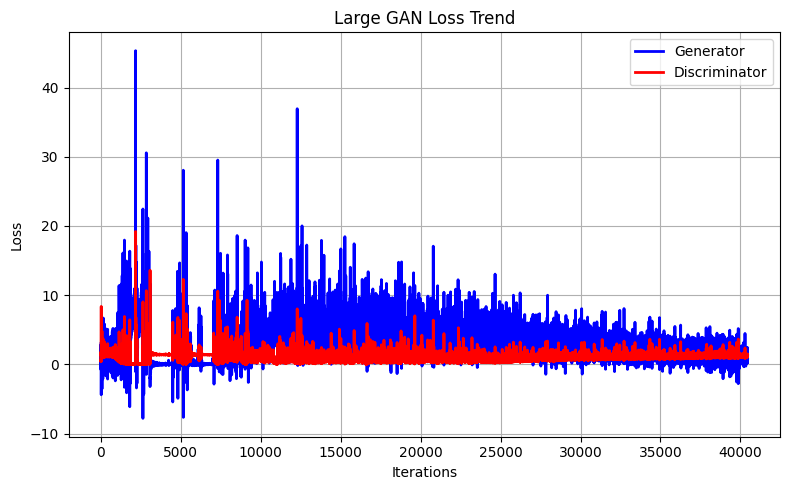

In [ ]:

iterations = list(range(1, len(losses_discriminator) + 1))

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generator", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminator", color="red", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Large GAN Loss Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gan_large.save("gan_large.pth")

Generator + Discriminator weights saved to gan_large.pth


load GAN large

In [ ]:
!gdown 1UpSS4HvAyLhDKCxeZ2IQAksKhejv2k0D

gan_large = MidiGAN.load(
    generator_class=GeneratorLarge,
    discriminator_class=DiscriminatorLarge,
    filepath="gan_large.pth",
    noise_dim=512,
    sequence_length=512,
    tokenizer=tokenizer,
    gen_kwargs=generator_config,
    disc_kwargs=discriminator_config,
)

## Generate Music

Below are generated folders and 150 midi files for all 3 trained models.

In [ ]:
num_midi_files = 150

output_folder = "generated_mini"
output_prefix = f"{output_folder}/generated_midi"

os.makedirs(output_folder, exist_ok=True)

gan_mini.generate_midi(n_samples=num_midi_files, output_prefix=output_prefix, device=device)

!zip -r genereted_mini.zip generated_mini

In [ ]:
num_midi_files = 150

output_folder = "generated_medium"
output_prefix = f"{output_folder}/generated_midi"

os.makedirs(output_folder, exist_ok=True)

gan_medium.generate_midi(n_samples=num_midi_files, output_prefix=output_prefix, device=device)

!zip -r genereted_medium.zip generated_medium

In [ ]:
num_midi_files = 150

output_folder = "generated_large"
output_prefix = f"{output_folder}/generated_midi"

os.makedirs(output_folder, exist_ok=True)

gan_large.generate_midi(n_samples=num_midi_files, output_prefix=output_prefix, device=device)

!zip -r genereted_large.zip generated_large

it is possible to download the generated midi of the following

In [ ]:
!gdown --id 1k-J8lSQlstUE9JaubvZfKHZOcHFno4Ps
!gdown --id 1mgJ1NA4A3sCvqmwD11pPMDUat4KjQqxd
!gdown --id 1HBvY5D9YKYMztFJgBT2lQ7Y_sl2_-Qxr

!unzip genereted_mini.zip
!unzip genereted_medium.zip
!unzip genereted_large.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1k-J8lSQlstUE9JaubvZfKHZOcHFno4Ps
To: /content/genereted_mini.zip
100% 214k/214k [00:00<00:00, 138MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mgJ1NA4A3sCvqmwD11pPMDUat4KjQqxd
To: /content/genereted_medium.zip
100% 198k/198k [00:00<00:00, 83.9MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: h

In [ ]:
!gdown --id 1ARhhdPxBfazNVg1TMkrXU1K6ce3DcOc8
!gdown --id 1VJSN9jD6HfX2nzfVhwYLfomtfOEaKXMe

!unzip dataset_test.zip
!unzip dataset_train.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XuDGsWg7UmEAePPuztb3Q6J-I15KGBnb
To: /content/dataset_test.zip
100% 12.2M/12.2M [00:00<00:00, 219MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1PdMp3rRLNbT45Es6qx9B0p8qb0EoSiLF
From (redirected): https://drive.google.com/uc?id=1PdMp3rRLNbT45Es6qx9B0p8qb0EoSiLF&confirm=t&uuid=25235b67-11f4-440a-8290-c82fdbf280f1
To: /content/dataset_train.zip
100% 46.1M/46.1M [00:00<00:00, 195MB/s]
Archive:  dataset_test.zip
   creating: dataset_test/
  inflating: dataset_test/MIDI-Unprocessed_1

#Performance evaluation

- Pitch_count: Measures the total number of notes in the song, indicating the overall amount of musical events.
- Note_density: Calculates the density of notes in relation to their total duration, useful for understanding how “dense” or “sparse” the musical texture is.
- Pitch_intervals: represents the average distance between consecutive notes, highlighting whether the melody proceeds with joint steps or with larger leaps.
- Pitch_range: indicates the overall range between the lowest and highest note, describing the breadth of the melodic register used.

KLD (Kullback–Leibler Divergence), which measures how much one probability distribution deviates from another, was used to compare the results of the previous metrics of the various models with the data from the dataset.

The pitch_class_histogram was also calculated, which is a metric representing the distribution of notes based on their pitch class, that is, the 12 semitones of the octave (C, C#, D, ..., B). Essentially, it counts how many times each pitch class appears in a song and normalizes its frequency.

The Rote Memorization Frequency (RM) metric measures how often repetitions of short sequences of notes present in the dataset appear in the generated midi files.

In [ ]:
def pitch_count(notes):
    """
    notes: list of int (pitch values)
    """
    return len(notes)


def note_density(notes, total_duration_sec):
    """
    notes: list of notes
    total_duration_sec: duration of piece in seconds
    """
    return len(notes) / total_duration_sec if total_duration_sec > 0 else 0

def pitch_intervals(notes):
    """
    Returns average absolute pitch interval between consecutive notes
    """
    if len(notes) < 2:
        return 0
    intervals = [abs(notes[i] - notes[i-1]) for i in range(1, len(notes))]
    return np.mean(intervals)

def pitch_class_histogram(notes):
    """
    Returns normalized histogram over 12 pitch classes
    """
    histogram = [0] * 12
    for n in notes:
        pc = int(round(n)) % 12
        histogram[pc] += 1
    return histogram

def duration_sec_midi(file_path)
    duration = extract_notes_from_midi(file_path)
    return duration

def extract_notes_from_midi(file_path):
    mid = mido.MidiFile(file_path)
    notes = []
    total_time = 0.0

    for track in mid.tracks:
        time_accum = 0
        for msg in track:
            time_accum += msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.append(msg.note)
        total_time = max(total_time, time_accum * mid.ticks_per_beat)
    duration_sec = mid.length
    return notes, duration_sec

def pitch_count_from_midi(file_path):
    notes, _ = extract_notes_from_midi(file_path)
    return pitch_count(notes)

def note_density_from_midi(file_path):
    notes, duration_sec = extract_notes_from_midi(file_path)
    return note_density(notes, duration_sec)

def pitch_intervals_from_midi(file_path):
    notes, _ = extract_notes_from_midi(file_path)
    return pitch_intervals(notes)

def pitch_range(file_path):
    """
    Calculates the pitch range of a MIDI file.
    """
    midi_data = pretty_midi.PrettyMIDI(file_path)
    all_notes = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            all_notes.append(note.pitch)
    if not all_notes:
        return 0
    pitch_max = max(all_notes)
    pitch_min = min(all_notes)
    return pitch_max - pitch_min


In [ ]:

def run_function_on_folder(folder_path, func, num=0):
    """
      Runs a function (MIDI wrapper) on all MIDI files in a folder.
    """
    results = []
    midi_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".mid", ".midi"))]

    for fname in midi_files:
        file_path = os.path.join(folder_path, fname)
        try:
            if num > 0:
                result = func(file_path, num)
            else:
                result = func(file_path)
            results.append(result)
        except Exception as e:
            print(f"Error with {fname}: {e}")
            results.append(None)

    return np.array(results, dtype=object)

def average_pitch_class_histogram(folder_path):
    """Calculates the average histogram of pitch classes (0–11) as a percentage of total notes."""
    histograms = []
    total_notes = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".mid", ".midi")):
            filepath = os.path.join(folder_path, filename)
            notes, _ = extract_notes_from_midi(filepath)
            if notes:
                hist = pitch_class_histogram(notes)
                histograms.append(hist)
                total_notes += sum(hist)

    if not histograms or total_notes == 0:
        return [0] * 12

    summed_hist = np.sum(histograms, axis=0)

    percentage_hist = (summed_hist / total_notes) * 100

    return percentage_hist.tolist()

In [ ]:

def extract_token_sequences(tokens, sequence_length):
    """
    Estrae tutte le sottosequenze di lunghezza fissa su GPU.
    """
    n_seqs = len(tokens) - sequence_length + 1
    if n_seqs <= 0:
        return cp.empty((0, sequence_length), dtype=cp.int32)

    return cp.stack([tokens[i:i+sequence_length] for i in range(n_seqs)])

def preprocess_real_midi_folder(real_midi_folder, sequence_length):
    """
    Estrae tutte le sottosequenze dai file MIDI reali e le restituisce come array CuPy.
    """
    all_notes_list = []

    for f in os.listdir(real_midi_folder):
        if f.lower().endswith(('.mid', '.midi')):
            path = os.path.join(real_midi_folder, f)
            notes, _ = extract_notes_from_midi(path)
            if notes:
                all_notes_list.append(cp.array(notes, dtype=cp.int32))

    if not all_notes_list:
        return cp.empty((0, sequence_length), dtype=cp.int32)

    all_notes = cp.concatenate(all_notes_list)
    sequences = extract_token_sequences(all_notes, sequence_length)
    sequences_unique = np.unique(cp.asnumpy(sequences), axis=0)
    return cp.asarray(sequences_unique, dtype=cp.int32)

def sequences_to_structured_array(seqs):
    if len(seqs) == 0:
        return cp.empty((0, seqs.shape[1]), dtype=cp.int32)
    return seqs.astype(cp.int32)

def calculate_rm_midi_preprocessed(
    generated_midi_folder: str,
    train_seqs_of_length_l: list[tuple],
    sequence_length: int
) -> float:
    """
    Calcola RM (Rote Memorization) su GPU usando sequenze reali precalcolate.
    """
    if not train_seqs_of_length_l:
        return 0.0

    train_array = cp.array(train_seqs_of_length_l, dtype=cp.int32)

    total_copied_sequences = 0
    total_sequences = 0

    for fname in tqdm(os.listdir(generated_midi_folder)):
        if fname.lower().endswith(('.mid', '.midi')):
            path = os.path.join(generated_midi_folder, fname)
            generated_notes, _ = extract_notes_from_midi(path)
            if not generated_notes:
                continue

            tokens_gpu = cp.array(generated_notes, dtype=cp.int32)
            gen_seqs = extract_token_sequences(tokens_gpu, sequence_length)

            if len(gen_seqs) == 0:
                continue

            copied_mask = cp.isin(gen_seqs.view(cp.int32).reshape(len(gen_seqs), -1),
                                  train_array.view(cp.int32).reshape(len(train_array), -1))

            total_copied_sequences += int(cp.sum(copied_mask).get())
            total_sequences += len(gen_seqs)

    return total_copied_sequences / total_sequences if total_sequences > 0 else 0.0


In [ ]:
def kld(p, q):
    """
    Kullback-Leibler Divergence between distributions p and q
    p, q: numpy arrays representing probability distributions
    """
    p = np.asarray(p, dtype=np.float64) + 1e-12
    q = np.asarray(q, dtype=np.float64) + 1e-12
    p /= p.sum()
    q /= q.sum()
    return np.sum(rel_entr(p, q))

def make_distribution(values, bins=50, range=None):
    hist, _ = np.histogram(values, bins=bins, range=range, density=False)
    hist = hist.astype(float)
    return hist / hist.sum() if hist.sum() > 0 else hist

def real_run_function_on_folder(real_folder):
    results = {}
    real_pc = run_function_on_folder(real_folder, pitch_count_from_midi)
    real_nd = run_function_on_folder(real_folder, note_density_from_midi)
    real_pi = run_function_on_folder(real_folder, pitch_intervals_from_midi)
    real_pr = run_function_on_folder(real_folder, pitch_range)
    real_ds = run_function_on_folder(real_folder, duration_sec_midi)

    results["pitch_count"] = real_pc
    results["note_density"] = real_nd
    results["pitch_intervals"] = real_pi
    results["pitch_range"] = real_pr
    results["duration_sec"] = real_ds

    return results

def compare_folders_with_kld(real_result, generated_folder):
    results = {}
    results_kld = {}

    gen_pc  = run_function_on_folder(generated_folder, pitch_count_from_midi)
    results_kld["pitch_count"] = kld(make_distribution(real_result["pitch_count"]), make_distribution(gen_pc))
    results["pitch_count"] = gen_pc

    gen_nd  = run_function_on_folder(generated_folder, note_density_from_midi)
    results_kld["note_density"] = kld(make_distribution(real_result["note_density"]), make_distribution(gen_nd))
    results["note_density"] = gen_nd

    gen_pi  = run_function_on_folder(generated_folder, pitch_intervals_from_midi)
    results_kld["pitch_intervals"] = kld(make_distribution(real_result["pitch_intervals"]), make_distribution(gen_pi))
    results["pitch_intervals"] = gen_pi

    gen_pr  = run_function_on_folder(generated_folder, pitch_range)
    results_kld["pitch_range"] = kld(make_distribution(real_result["pitch_range"]), make_distribution(gen_pr))
    results["pitch_range"] = gen_pr

    gen_ds  = run_function_on_folder(generated_folder, duration_sec_midi)
    results["duration_sec"] = gen_ds

    return results_kld, results


In [ ]:
generated_mini_folder = "/content/generated_mini"
generated_medium_folder = "/content/generated_medium"
generated_large_folder = "/content/generated_large"
real_folder = "/content/dataset_test"

real_result = real_run_function_on_folder(real_folder)

results_mini_kld, results_mini = compare_folders_with_kld(real_result, generated_mini_folder)
results_medium_kld, results_medium = compare_folders_with_kld(real_result, generated_medium_folder)
results_large_kld, results_large = compare_folders_with_kld(real_result, generated_large_folder)

print("Result real:\n")
for key, value in real_result.items():
  mean_val = np.mean(value)
  print(f"{key} = {mean_val:.4f}")

print("\nResult mini:\n")
for key, value in results_mini.items():
  mean_val = np.mean(value)
  print(f"{key} = {mean_val:.4f}")

print("\nResult medium:\n")
for key, value in results_medium.items():
  mean_val = np.mean(value)
  print(f"{key} = {mean_val:.4f}")

print("\nResult large:\n")
for key, value in results_large.items():
  mean_val = np.mean(value)
  print(f"{key} = {mean_val:.4f}")

print("\n\n")
print("KLD result:\n")

print("Result mini:\n")
for key, value in results_mini_kld.items():
  print(f"{key}: KLD = {value:.4f}")

print("\nResult medium:\n")
for key, value in results_medium_kld.items():
  print(f"{key}: KLD = {value:.4f}")

print("\nResult large:\n")
for key, value in results_large_kld.items():
  print(f"{key}: KLD = {value:.4f}")

Result real:

pitch_count = 5713.4980
note_density = 10.1169
pitch_intervals = 11.5795
pitch_range = 67.4824
Result mini:

pitch_count = 288.8533
note_density = 3.1097
pitch_intervals = 16.3812
pitch_range = 73.2400
Result medium:

pitch_count = 257.5333
note_density = 2.8796
pitch_intervals = 16.4975
pitch_range = 73.1467
Result large:

pitch_count = 280.3867
note_density = 3.0941
pitch_intervals = 16.3915
pitch_range = 72.8733



KLD result:

Result mini:

pitch_count: KLD = 3.7164
note_density: KLD = 2.9825
pitch_intervals: KLD = 3.4186
pitch_range: KLD = 9.9604

Result medium:

pitch_count: KLD = 4.7558
note_density: KLD = 0.5715
pitch_intervals: KLD = 1.5066
pitch_range: KLD = 14.0198

Result large:

pitch_count: KLD = 13.2346
note_density: KLD = 1.5377
pitch_intervals: KLD = 1.0890
pitch_range: KLD = 12.9819


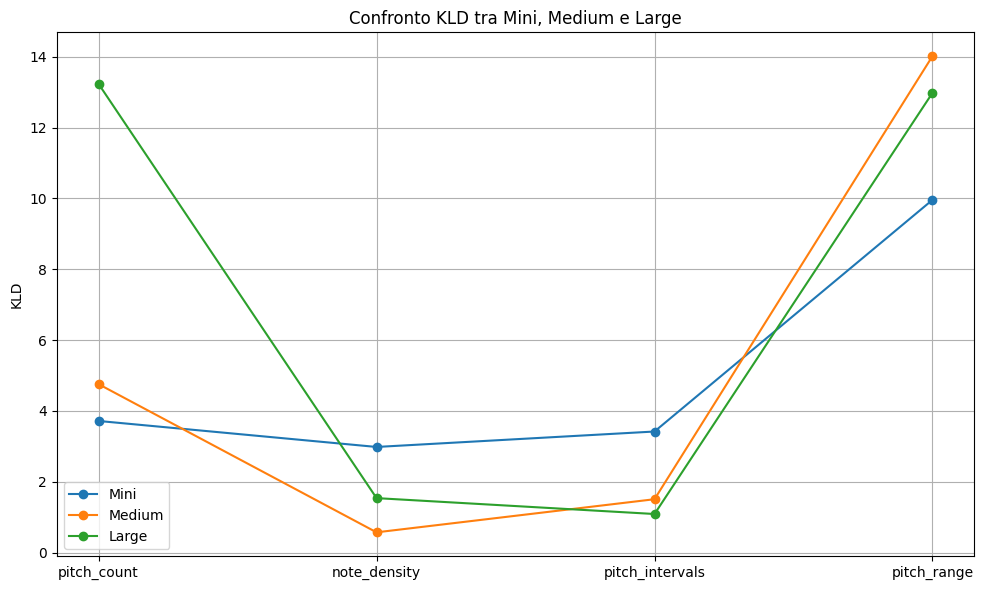

In [ ]:
metrics = list(results_mini_kld.keys())
values_mini = list(results_mini_kld.values())
values_medium = list(results_medium_kld.values())
values_large = list(results_large_kld.values())

plt.figure(figsize=(10,6))
plt.plot(metrics, values_mini, marker="o", label="Mini")
plt.plot(metrics, values_medium, marker="o", label="Medium")
plt.plot(metrics, values_large, marker="o", label="Large")

plt.ylabel("KLD")
plt.title("Confronto KLD tra Mini, Medium e Large")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Below is the calculated Rote Memorization Frequency of the midi generated by the various models on sequences of length of 3 and 5 notes.

In [ ]:
train_seqs_5 = preprocess_real_midi_folder("dataset_train/", sequence_length=5)
train_seqs_3 = preprocess_real_midi_folder("dataset_train/", sequence_length=3)
rm_mini_5 = calculate_rm_midi_preprocessed("generated_mini/", train_seqs_5, sequence_length=5)
rm_mini_3 = calculate_rm_midi_preprocessed("generated_mini/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency mini: \n")
print("Rote Memorization Frequency 3:", rm_mini_3)
print("Rote Memorization Frequency 5:", rm_mini_5)
rm_medium_5 = calculate_rm_midi_preprocessed("generated_medium/", train_seqs_5, sequence_length=5)
rm_medium_3 = calculate_rm_midi_preprocessed("generated_medium/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency medium: \n")
print("Rote Memorization Frequency 3:", rm_medium_3)
print("Rote Memorization Frequency 5:", rm_medium_5)
rm_large_5 = calculate_rm_midi_preprocessed("generated_large/", train_seqs_5, sequence_length=5)
rm_large_3 = calculate_rm_midi_preprocessed("generated_large/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency large: \n")
print("Rote Memorization Frequency 3:", rm_large_3)
print("Rote Memorization Frequency 5:", rm_large_5)

  7%|▋         | 10/150 [02:44<38:18, 16.42s/it]


KeyboardInterrupt: 

In [ ]:
train_seqs_5 = preprocess_real_midi_folder("dataset_test/", sequence_length=5)
train_seqs_3 = preprocess_real_midi_folder("dataset_test/", sequence_length=3)
rm_mini_5 = calculate_rm_midi_preprocessed("generated_mini/", train_seqs_5, sequence_length=5)
rm_mini_3 = calculate_rm_midi_preprocessed("generated_mini/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency mini: \n")
print("Rote Memorization Frequency 3:", rm_mini_3)
print("Rote Memorization Frequency 5:", rm_mini_5)
rm_medium_5 = calculate_rm_midi_preprocessed("generated_medium/", train_seqs_5, sequence_length=5)
rm_medium_3 = calculate_rm_midi_preprocessed("generated_medium/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency medium: \n")
print("Rote Memorization Frequency 3:", rm_medium_3)
print("Rote Memorization Frequency 5:", rm_medium_5)
rm_large_5 = calculate_rm_midi_preprocessed("generated_large/", train_seqs_5, sequence_length=5)
rm_large_3 = calculate_rm_midi_preprocessed("generated_large/", train_seqs_3, sequence_length=3)
print("Rote Memorization Frequency large: \n")
print("Rote Memorization Frequency 3:", rm_large_3)
print("Rote Memorization Frequency 5:", rm_large_5)

the following graph shows the pitch_class_histogram of the midi of the various models and that of the dataset

In [ ]:
def plot_histograms(folders, labels):
    pitch_classes = ["C", "C#", "D", "D#", "E", "F",
                     "F#", "G", "G#", "A", "A#", "B"]

    plt.figure(figsize=(12, 8))

    for i, folder in enumerate(folders):
        avg_hist = average_pitch_class_histogram(folder)
        plt.subplot(2, 2, i + 1)
        plt.bar(pitch_classes, avg_hist)
        plt.title(labels[i])
        plt.xlabel("Pitch Class")
        plt.ylabel("Normalized Average")
        plt.ylim(0, 20)

    plt.tight_layout()
    plt.show()

folders = [
    "/content/dataset_test",
    "/content/generated_mini",
    "/content/generated_medium",
    "/content/generated_large"
]
labels = ["real MIDI", "mini GAN MIDI", "medium GAN MIDI"]

plot_histograms(folders, labels)

In [ ]:
real_pch = average_pitch_class_histogram("/content/dataset_test")
mini_pch = average_pitch_class_histogram("/content/generated_mini")
medium_pch = average_pitch_class_histogram("/content/generated_medium")
large_pch = average_pitch_class_histogram("/content/generated_large")

kld_real_mini = kld(real_pch, mini_pch)
kld_real_medium = kld(real_pch, medium_pch)
kld_real_large = kld(real_pch, large_pch)

print("KLD real vs mini:", kld_real_mini)
print("KLD real vs medium:", kld_real_medium)
print("KLD real vs large:", kld_real_large)